In [42]:
import numpy as np
import nibabel as nib
import os
from nilearn import plotting
from nilearn import image
from nilearn import input_data
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### import data

*run info:*

In [84]:
#run_file = os.path.abspath('data/task01_run01.nii.gz')
run_file = os.path.join('/Users/kevinsitek/om/om/scratch/Fri/ksitek/timeseries/',
                        'voice996_task005_run001_emosent_dtype_mcf_mask_smooth_mask_gms_tempfilt_maths.nii.gz')
run_data = nib.load(run_file)

In [85]:
print(image.load_img(run_data).shape)

(108, 108, 65, 42)


In [86]:
one_time = image.index_img(run_data, 0)
print(one_time.shape)

(108, 108, 65)


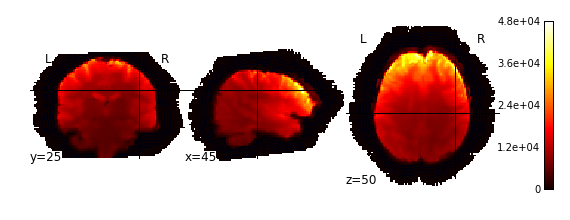

In [87]:
plotting.plot_stat_map(one_time,cut_coords=(45,25,50),bg_img=None)

*condition info:*

In [54]:
# read in individual condition times:
cond001 = np.genfromtxt('data/onsets/run001/cond001.txt')
cond002 = np.genfromtxt('data/onsets/run001/cond002.txt')
cond003 = np.genfromtxt('data/onsets/run001/cond003.txt')

(12, 3)


array([[  25.135,    1.1  ,    1.   ],
       [  33.13 ,    1.1  ,    1.   ],
       [  49.121,    1.1  ,    1.   ],
       [  57.117,    1.1  ,    1.   ],
       [  89.098,    1.1  ,    1.   ],
       [ 101.091,    1.1  ,    1.   ],
       [ 105.089,    1.1  ,    1.   ],
       [ 125.078,    1.1  ,    1.   ],
       [ 149.064,    1.1  ,    1.   ],
       [ 169.053,    1.1  ,    1.   ],
       [ 177.048,    1.1  ,    1.   ],
       [ 181.046,    1.1  ,    1.   ]])

In [68]:
# combine individual conditions into one array:
run001_conds = np.zeros((36,4))
run001_conds[:12,:3] = cond001
run001_conds[:12,3] = 1

run001_conds[12:24,:3] = cond002
run001_conds[12:24,3] = 2

run001_conds[24:36,:3] = cond003
run001_conds[24:36,3] = 3

In [75]:
# order the array:
run001_conds_ordered = run001_conds[run001_conds[:,0].argsort()]

In [78]:
# add 'rest' conditions to the array
# by fitting the ordered data into an array of zeros:
run001_cond_inc_rest = np.zeros((48))
run001_cond_inc_rest[((np.round(run001_conds_ordered[:,0])-1)/4).astype(int)] = run001_conds_ordered[:,3]

In [79]:
# how does it look:
run001_cond_inc_rest

array([ 2.,  2.,  3.,  0.,  3.,  3.,  1.,  2.,  1.,  2.,  2.,  2.,  1.,
        0.,  1.,  2.,  0.,  3.,  2.,  0.,  2.,  0.,  1.,  3.,  0.,  1.,
        1.,  3.,  3.,  0.,  3.,  1.,  0.,  3.,  3.,  0.,  2.,  1.,  0.,
        2.,  3.,  2.,  1.,  0.,  1.,  1.,  3.,  0.])

In [89]:
# now make a list of label words instead of number codes:
labels_run001 = []
for c in run001_cond_inc_rest:
    if c==0:
        labels_run001.append('rest')
    elif c==1:
        labels_run001.append('neutral')
    elif c==2:
        labels_run001.append('happy')
    elif c==3:
        labels_run001.append('sad')
labels_run001[:10]

['happy',
 'happy',
 'sad',
 'rest',
 'sad',
 'sad',
 'neutral',
 'happy',
 'neutral',
 'happy']

In [90]:
# now do it all for run 2:
cond001 = np.genfromtxt('data/onsets/run002/cond001.txt')
cond002 = np.genfromtxt('data/onsets/run002/cond002.txt')
cond003 = np.genfromtxt('data/onsets/run002/cond003.txt')

run002_conds = np.zeros((36,4))
run002_conds[:12,:3] = cond001
run002_conds[:12,3] = 1

run002_conds[12:24,:3] = cond002
run002_conds[12:24,3] = 2

run002_conds[24:36,:3] = cond003
run002_conds[24:36,3] = 3

run002_conds_ordered = run002_conds[run002_conds[:,0].argsort()]

run002_cond_inc_rest = np.zeros((48))
run002_cond_inc_rest[((np.round(run002_conds_ordered[:,0])-1)/4).astype(int)] = run002_conds_ordered[:,3]

labels_run002 = []
for c in run002_cond_inc_rest:
    if c==0:
        labels_run002.append('rest')
    elif c==1:
        labels_run002.append('neutral')
    elif c==2:
        labels_run002.append('happy')
    elif c==3:
        labels_run002.append('sad')
labels_run002[:10]

['neutral',
 'sad',
 'rest',
 'neutral',
 'happy',
 'happy',
 'rest',
 'sad',
 'happy',
 'happy']

In [92]:
np.savetxt('data/labels_run001.txt',run001_cond_inc_rest)
np.savetxt('data/labels_run002.txt',run002_cond_inc_rest)

** set up model **

In [47]:
from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

# Load Target labels
import numpy as np
labels = np.recfromcsv(data_files.session_target[0], delimiter=" ")


# Restrict to face and house conditions
target = labels['labels']
condition_mask = np.logical_or(target == b"face", target == b"house")

# Split data into train and test samples, using the chunks
condition_mask_train = np.logical_and(condition_mask, labels['chunks'] <= 6)
condition_mask_test = np.logical_and(condition_mask, labels['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = target[condition_mask_train]
y_test = target[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

In [49]:
labels

rec.array([('rest', 0), ('rest', 0), ('rest', 0), ..., ('rest', 11), ('rest', 11),
 ('rest', 11)], 
          dtype=[('labels', 'S12'), ('chunks', '<i8')])

In [55]:
y_train

array(['face', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'house', 'house', 'house', 'house', 'house', 'house',
       'house', 'house', 'house', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'house', 'house', 'house', 'house',
       'house', 'house', 'house', 'house', 'house', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'house', 'house',
       'house', 'house', 'house', 'house', 'house', 'house', 'house',
       'house', 'house', 'house', 'house', 'house', 'house', 'house',
       'house', 'house', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'house', 'house', 'house', 'house', 'house',
       'house', 'house', 'house', 'house', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'house', 'house', 'house',
       'house', 'house', 'house', 'house', 'house', 'house', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
.........................................................................[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.8min finished
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array b

Time Elapsed: 285.267 seconds, 4 minutes.
TV-l1 classification accuracy : 95.5556%


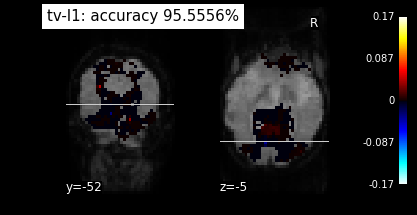

In [48]:
decoder = SpaceNetClassifier(memory="nilearn_cache", penalty='tv-l1')
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("TV-l1 classification accuracy : %g%%" % accuracy)

# Visualization
coef_img = decoder.coef_img_
plot_stat_map(coef_img, background_img,
              title="tv-l1: accuracy %g%%" % accuracy,
              cut_coords=(-52, -5), display_mode="yz")

# Save the coefficients to a nifti file
coef_img.to_filename('haxby_tv-l1_weights.nii')
show()